# Plots for COLING paper

This notebook will produce the plots from the eval runs 

In [1]:
import json
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm

## Translators

Ignoring the falcom models 
Ran the data through TLDL parser in DIARC

In [ ]:
# Regular versions
t_l3_context_fn = "../data/evals/translator-simple_english-30k-context-llama2-3b_evaluation_parsed.json"
t_l7_context_fn = "../data/evals/translator-simple_english-30k-context-llama2-7b_evaluation_parsed.json"

t_l3_fn = "../data/evals/translator-simple_english-30k-no-context-llama2-3b_evaluation_parsed.json"
t_l7_fn = "../data/evals/translator-simple_english-30k-no-context-llama2-7b_evaluation_parsed.json"

all_translators = [t_l3_fn, t_l7_fn, t_l3_context_fn, t_l7_context_fn]

In [2]:
# Novelty Versions

t_l3_context_fn = "../data/evals/translator-simple_english-2k-novelty-context-llama2-3b_evaluation_parsed.json"
t_l7_context_fn = "../data/evals/translator-simple_english-2k-novelty-context-llama2-7b_evaluation_parsed.json"

t_l3_fn = "../data/evals/translator-simple_english-2k-novelty-no-context-llama2-3b_evaluation_parsed.json"
t_l7_fn = "../data/evals/translator-simple_english-2k-novelty-no-context-llama2-7b_evaluation_parsed.json"

all_translators = [t_l3_fn, t_l7_fn, t_l3_context_fn, t_l7_context_fn]

In [3]:
# Run this cell to get a data table and df for the translators evaluations

from scripts.evaluate import evaluate
from gsp.preparation import deconstruct 

general_table_translators = [] 
metrics = ['valid_json','intent_correct','cpc_name_correct','spc_length_correct','is_isomorphic','is_matched']

for t_fn in tqdm(all_translators, position=0, leave=True, desc="Parsers"):
    filepath = Path(t_fn)
    item = {}
    if "no-context" in filepath.stem:
        model_name = "".join(filepath.stem.split("-")[-2:]).split("_")[0]
    else:
        model_name = "".join(filepath.stem.split("-")[-2:]).split("_")[0] + "_context"
    item['model-name'] = model_name.replace("_","-")

    print(f"Processing model: {model_name}")

    # put in a dataframe
    with open(t_fn, "r") as f:
        t = json.load(f)
    df = pd.DataFrame(t)

    # whether or not the simple english could actually be parsed
    item['is_parsed'] = df.value_counts('is_parsed', normalize=True)[True]

    print("Dataframe initialized with length: ", len(df))
    # deconstruct the parse if there is a parse
    decons = []
    for index, row in tqdm(df.iterrows(), position=1, leave=False, desc="Data items"):
        if row['parse']:
            try:
                deconstructed = deconstruct(row['parse'])
            except IndexError:
                deconstructed = {}
                
        else:
            deconstructed = {}

        decons.append(deconstructed)
    df['deconstructed'] = decons

    # evaluate
    evals = []
    for index, row in tqdm(df.iterrows(), position=1, leave=False, desc="Data items"):
        evaluation = evaluate(row['deconstructed'], row['json_semantics'])
        evals.append(evaluation)
        for metric in metrics:   
            if metric in evaluation:
                df.at[index, metric] = evaluation[metric]
            else:
                df.at[index, metric] = False

    df['evaluation'] = evals

    # "True" Value counts
    for metric in metrics:
        
        try:
            item[metric.replace("_","-")]  = df.value_counts(metric, normalize=True)[True]
        except KeyError:
            item[metric.replace("_","-")]  = 0.0 
    # let's get the precision and recall metrics

    for index, row in df.iterrows():
        if "spc_accuracy" in row['evaluation']:
            if row['evaluation']['spc_accuracy']:
                df.at[index, 'spc_precision'] = row['evaluation']['spc_accuracy']['precision']
                df.at[index, 'spc_recall'] = row['evaluation']['spc_accuracy']['recall']
            else:
                df.at[index, 'spc_precision'] = 0
                df.at[index, 'spc_recall'] = 0

    item['spc-precision'] = df['spc_precision'].mean()
    #item['spc-precision-std'] = df['spc_precision'].std()
    item['spc-recall'] = df['spc_recall'].mean()
    #item['spc-recall-std'] = df['spc_recall'].std()

    df.to_csv(f"{t_fn}_cleaned.csv", index=False)

    general_table_translators.append(item)
df_table = pd.DataFrame(general_table_translators)
df_table.to_csv(f"translators_summary_table.csv", index=False)

Parsers:   0%|          | 0/4 [00:00<?, ?it/s]

Processing model: llama23b
Dataframe initialized with length:  2473


Data items: 0it [00:00, ?it/s]

Data items: 0it [00:00, ?it/s]

	>> Checking Intent
	>> Checking Intent
FAILED: Checking intent.
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False} 


FAILED: Checking CPC name
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False} 


FAILED: Checking SPC counting
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False, 'spc_length_correct': False} 


FAILED: Checking SPC accuracy check
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': 

/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and w

	>> Checking Intent
	>> Checking Intent
	>> Checking Intent
	>> Checking Intent
	>> Checking Intent
	>> Checking Intent
	>> Checking Intent
	>> Checking Intent
	>> Checking Intent
FAILED: Checking intent.
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'hide(self:agent,VAR0)', 'supplemental_semantics': ['spoon(VAR0)', 'handbag(VAR1)', 'INDEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False} 


FAILED: Checking CPC name
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'hide(self:agent,VAR0)', 'supplemental_semantics': ['spoon(VAR0)', 'handbag(VAR1)', 'INDEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False} 


FAILED: Checking SPC counting
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'hide(self:agent,VAR0)', 'supplemental_semantics': ['spoon(VAR0)', 'handbag(VAR1)', 'INDEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_na

Data items: 0it [00:00, ?it/s]

Data items: 0it [00:00, ?it/s]

	>> Checking Intent
	>> Checking Intent
FAILED: Checking intent.
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False} 


FAILED: Checking CPC name
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False} 


FAILED: Checking SPC counting
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False, 'spc_length_correct': False} 


FAILED: Checking SPC accuracy check
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': 

/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and w

	>> Checking Intent
FAILED: Checking intent.
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False} 


FAILED: Checking CPC name
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False} 


FAILED: Checking SPC counting
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False, 'spc_length_correct': False} 


FAILED: Checking SPC accuracy check
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'push(self:agent,VAR0)', 'supplemental_semantics': ['hairdrier(VAR0)']}, 'prediction': {}, 'valid_json': Tr

/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and 

	>> Checking Intent
FAILED: Checking intent.
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'spin(self:agent,VAR0)', 'supplemental_semantics': ['refrigerator(VAR0)', 'sheep(VAR1)', 'DEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False} 


FAILED: Checking CPC name
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'spin(self:agent,VAR0)', 'supplemental_semantics': ['refrigerator(VAR0)', 'sheep(VAR1)', 'DEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False} 


FAILED: Checking SPC counting
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'spin(self:agent,VAR0)', 'supplemental_semantics': ['refrigerator(VAR0)', 'sheep(VAR1)', 'DEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False, 'spc_length_correct': False} 


FAILED: Checking SPC accuracy check
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition':

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Processing model: llama27b_context
Dataframe initialized with length:  2473


Data items: 0it [00:00, ?it/s]

Data items: 0it [00:00, ?it/s]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = evaluation[metric]
/tmp/ipykernel_178426/851630585.py:51: FutureWarning: Setting an item of incompatible 

 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'pushrightof(self:agent,VAR0,VAR1)', 'supplemental_semantics': ['keyboard(VAR0)', 'glass(VAR1)', 'DEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False} 


FAILED: Checking CPC name
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'pushrightof(self:agent,VAR0,VAR1)', 'supplemental_semantics': ['keyboard(VAR0)', 'glass(VAR1)', 'DEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False} 


FAILED: Checking SPC counting
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'pushrightof(self:agent,VAR0,VAR1)', 'supplemental_semantics': ['keyboard(VAR0)', 'glass(VAR1)', 'DEFINITE(VAR0)']}, 'prediction': {}, 'valid_json': True, 'intent_correct': False, 'cpc_name_correct': False, 'spc_length_correct': False} 


FAILED: Checking SPC accuracy check
Item: 
 {'truth': {'intent': 'INSTRUCT', 'central_proposition': 'pushrightof(self:agent,VAR

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [4]:
df_table_trans = pd.DataFrame(general_table_translators)
print(df_table_trans.to_latex(index=False))
df_table_trans.head()

\begin{tabular}{lrrrrrrrrr}
\toprule
model-name & is_parsed & valid-json & intent-correct & cpc-name-correct & spc-length-correct & is-isomorphic & is-matched & spc-precision & spc-recall \\
\midrule
llama23b & 0.417307 & 1.000000 & 0.413668 & 0.000000 & 0.272543 & 0.112818 & 0.000000 & 0.273487 & 0.364604 \\
llama27b & 0.532956 & 1.000000 & 0.531743 & 0.000000 & 0.329155 & 0.148403 & 0.000000 & 0.350452 & 0.476614 \\
llama23b-context & 0.188435 & 1.000000 & 0.180348 & 0.000000 & 0.127376 & 0.049333 & 0.000000 & 0.127241 & 0.154468 \\
llama27b-context & 0.350991 & 1.000000 & 0.350182 & 0.000000 & 0.263243 & 0.123736 & 0.000000 & 0.248955 & 0.303680 \\
\bottomrule
\end{tabular}



model-name  is_parsed  valid-json  intent-correct  cpc-name-correct  \
0          llama23b   0.417307         1.0        0.413668               0.0   
1          llama27b   0.532956         1.0        0.531743               0.0   
2  llama23b-context   0.188435         1.0        0.180348               0.0   
3  llama27b-context   0.350991         1.0        0.350182               0.0   

   spc-length-correct  is-isomorphic  is-matched  spc-precision  spc-recall  
0            0.272543       0.112818         0.0       0.273487    0.364604  
1            0.329155       0.148403         0.0       0.350452    0.476614  
2            0.127376       0.049333         0.0       0.127241    0.154468  
3            0.263243       0.123736         0.0       0.248955    0.303680

## Parsers

For now, I'm ignoring the Falcon models.

In [ ]:
#p_f7_context_fn = "../data/evals/parser-info_structure-30k-context-falcon-7b_evaluation.json"
p_l3_context_fn = "../data/evals/parser-info_structure-30k-context-llama2-3b_evaluation.json"
p_l7_context_fn = "../data/evals/parser-info_structure-30k-context-llama2-7b_evaluation.json"

#p_f7_fn = "../data/evals/parser-info_structure-30k-no-context-falcon-7b_evaluation.json"
p_l3_fn= "../data/evals/parser-info_structure-30k-no-context-llama2-3b_evaluation.json"
p_l7_fn = "../data/evals/parser-info_structure-30k-no-context-llama2-7b_evaluation.json"


parsers_fn = [p_l3_fn, p_l7_fn]
parsers_context_fn = [p_l3_context_fn, p_l7_context_fn]
all_parsers = parsers_fn + parsers_context_fn

In [5]:
# Novelty version
p_l3_context_fn = "../data/evals/parser-info_structure-2k-novelty-context-llama2-3b_evaluation.json"
p_l7_context_fn = "../data/evals/parser-info_structure-2k-novelty-context-llama2-7b_evaluation.json"

#p_f7_fn = "../data/evals/parser-info_structure-30k-no-context-falcon-7b_evaluation.json"
p_l3_fn= "../data/evals/parser-info_structure-2k-novelty-no-context-llama2-3b_evaluation.json"
p_l7_fn = "../data/evals/parser-info_structure-2k-novelty-no-context-llama2-7b_evaluation.json"


parsers_fn = [p_l3_fn, p_l7_fn]
parsers_context_fn = [p_l3_context_fn, p_l7_context_fn]
all_parsers = parsers_fn + parsers_context_fn

### General Table

In [6]:
# This generates a summary table and cleaned eval files for the parsers experiments.
# the cleaned ones can be used for ploitting 

general_table = []

for p_fn in tqdm(all_parsers, position=0, leave=True, desc="Parsers"):
    filepath = Path(p_fn)
    item = {}
    if "no-context" in filepath.stem:
        model_name = "".join(filepath.stem.split("-")[-2:]).split("_")[0]
    else:
        model_name = "".join(filepath.stem.split("-")[-2:]).split("_")[0] + "_context"
    item['model-name'] = model_name.replace("_","-")

    print(f"Processing model: {model_name}")

    # get the dataframe
    with open(p_fn, "r") as f:
        p = json.load(f)
    df = pd.DataFrame(p)

    metrics = ['valid_json','intent_correct','cpc_name_correct','spc_length_correct','is_isomorphic','is_matched']

    # Iterate through DF and add columns
    for index, row in tqdm(df.iterrows(), position=1, leave=False, desc="Data items"):
        for metric in metrics:   
            if metric in row['evaluation']:
                df.at[index, metric] = row['evaluation'][metric]
            else:
                df.at[index, metric] = False

    print("Evaluation done. Counting up Trues/Falses")
    # "True" Value counts
    for metric in metrics:
        try:
            item[metric.replace("_","-")]  = df.value_counts(metric, normalize=True)[True]
        except KeyError:
            item[metric.replace("_","-")] = 0.0

    # let's get the precision and recall metrics

    for index, row in df.iterrows():
        if "spc_accuracy" in row['evaluation']:
            if row['evaluation']['spc_accuracy']:
                df.at[index, 'spc_precision'] = row['evaluation']['spc_accuracy']['precision']
                df.at[index, 'spc_recall'] = row['evaluation']['spc_accuracy']['recall']
            else:
                df.at[index, 'spc_precision'] = 0
                df.at[index, 'spc_recall'] = 0

    item['spc-precision'] = df['spc_precision'].mean()
    #item['spc-precision-std'] = df['spc_precision'].std()
    item['spc-recall'] = df['spc_recall'].mean()
    #item['spc-recall-std'] = df['spc_recall'].std()

    # will need to handle accuracy separately
    df.to_csv(f"{p_fn}_cleaned.csv", index=False)
    general_table.append(item)   

df_table = pd.DataFrame(general_table)
df_table.to_csv(f"parsers_summary_table.csv", index=False)

Parsers:   0%|          | 0/4 [00:00<?, ?it/s]

Processing model: llama23b


Data items: 0it [00:00, ?it/s]

/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is

Evaluation done. Counting up Trues/Falses
Processing model: llama27b


Data items: 0it [00:00, ?it/s]

/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is

Evaluation done. Counting up Trues/Falses
Processing model: llama23b_context


Data items: 0it [00:00, ?it/s]

/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype i

Evaluation done. Counting up Trues/Falses
Processing model: llama27b_context


Data items: 0it [00:00, ?it/s]

/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, metric] = row['evaluation'][metric]
/tmp/ipykernel_178426/40499872.py:28: FutureWarning: Setting an item of incompatible dtype is

Evaluation done. Counting up Trues/Falses


In [7]:
df_table = pd.DataFrame(general_table)

In [8]:
df_table.head()

model-name  valid-json  intent-correct  cpc-name-correct  \
0          llama23b    0.995552        0.978973          0.001213   
1          llama27b    0.999596        0.962394          0.016983   
2  llama23b-context    0.442378        0.986656          0.000809   
3  llama27b-context    1.000000        0.957946          0.228872   

   spc-length-correct  is-isomorphic  is-matched  spc-precision  spc-recall  
0            0.528508       0.234533    0.000000       0.599137    0.891630  
1            0.549535       0.227254    0.000404       0.621310    0.902952  
2            0.029923       0.006066    0.000000       0.390315    0.811161  
3            0.537404       0.224019    0.028306       0.597520    0.877342

In [9]:
print(df_table.to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
model-name & valid-json & intent-correct & cpc-name-correct & spc-length-correct & is-isomorphic & is-matched & spc-precision & spc-recall \\
\midrule
llama23b & 0.995552 & 0.978973 & 0.001213 & 0.528508 & 0.234533 & 0.000000 & 0.599137 & 0.891630 \\
llama27b & 0.999596 & 0.962394 & 0.016983 & 0.549535 & 0.227254 & 0.000404 & 0.621310 & 0.902952 \\
llama23b-context & 0.442378 & 0.986656 & 0.000809 & 0.029923 & 0.006066 & 0.000000 & 0.390315 & 0.811161 \\
llama27b-context & 1.000000 & 0.957946 & 0.228872 & 0.537404 & 0.224019 & 0.028306 & 0.597520 & 0.877342 \\
\bottomrule
\end{tabular}



## PLOTTING

I need to merge the datasets and plot them 

In [10]:
## PARSERS 

#p_f7_context_fn = "../data/evals/parser-info_structure-30k-context-falcon-7b_evaluation.json"
p_l3_context_fn_c = "../data/evals/parser-info_structure-2k-novelty-context-llama2-3b_evaluation.json_cleaned.csv"
p_l7_context_fn_c = "../data/evals/parser-info_structure-2k-novelty-context-llama2-7b_evaluation.json_cleaned.csv"

#p_f7_fn = "../data/evals/parser-info_structure-30k-no-context-falcon-7b_evaluation.json"
p_l3_fn_c = "../data/evals/parser-info_structure-2k-novelty-no-context-llama2-3b_evaluation.json_cleaned.csv"
p_l7_fn_c = "../data/evals/parser-info_structure-2k-novelty-no-context-llama2-7b_evaluation.json_cleaned.csv"


parsers_fn_c = [p_l3_fn_c, p_l7_fn_c]
parsers_context_fn_c = [p_l3_context_fn_c, p_l7_context_fn_c]
all_parsers_c = parsers_fn_c + parsers_context_fn_c

In [11]:
from tqdm.notebook import tqdm 
import pandas as pd

dfs = []
for p in tqdm(all_parsers_c):
    print(p)
    df = pd.read_csv(p)
    print(len(df))
    dfs.append(df)
print("concatenating")
df = pd.concat(dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

../data/evals/parser-info_structure-2k-novelty-no-context-llama2-3b_evaluation.json_cleaned.csv
2473
../data/evals/parser-info_structure-2k-novelty-no-context-llama2-7b_evaluation.json_cleaned.csv
2473
../data/evals/parser-info_structure-2k-novelty-context-llama2-3b_evaluation.json_cleaned.csv
2473
../data/evals/parser-info_structure-2k-novelty-context-llama2-7b_evaluation.json_cleaned.csv
2473
concatenating


In [12]:
df.iloc[0]

utterance                             could you please move the hair dryer?
goal_semantics            INSTRUCT(marlow,self:agent,push(self:agent,VAR...
base_utterance                                         shove the hair drier
json_semantics            {'intent': 'INSTRUCT', 'central_proposition': ...
intent                                                             INSTRUCT
central_proposition                                   push(self:agent,VAR0)
supplemental_semantics                                  ['hairdrier(VAR0)']
stylizer                                     style:DirectnessStyleAugmenter
augmenter                                                               NaN
actions                   ['throwamong', 'placeIn', 'lookForObject', 'pl...
properties                ['this', 'it', 'that', 'thing', 'those', 'they...
prompt_template           \n### instruction\n{instruction}\n\n### exampl...
text                      \n### instruction\nGiven an utterance, extract...
input       

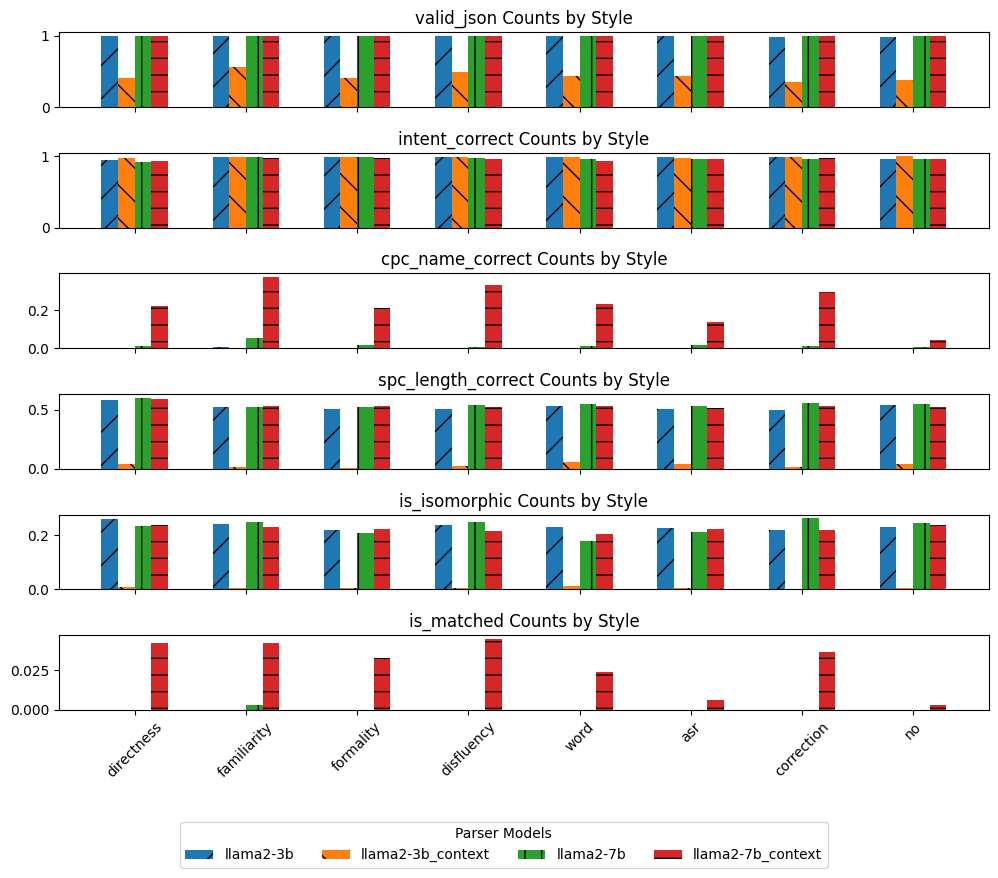

In [13]:
# Plotting 

import matplotlib.pyplot as plt
import numpy as np
import re

def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]
    
def get_model_name(text):
    if "no-context" in text:
        return "-".join(text.split("/")[1].split("-")[-2:])
    else:
        return "-".join(text.split("/")[1].split("-")[-2:]) + "_context"

def get_style_name(text):
    t = text.split(":")[1]
    return camel_case_split(t)[0].lower()

# shorten the names of the models 
# get all unique names - this can easily hande a couple tenthousand names
models = set(df["model"])
styles = set(df["stylizer"])

# create mapper: you would use fake.last_name() instead of 42+i
# mapper = {k: fake.last_name() for k in all_names }
mapper = {m: get_model_name(m)  for m in models}
mapper_styles = {s: get_style_name(s) for s in styles}

# apply it
df["model"] = df["model"].map(mapper)
df["stylizer"] = df['stylizer'].map(mapper_styles)

# List of evaluation columns
eval_columns = ['valid_json', 'intent_correct', 'cpc_name_correct','spc_length_correct', 'is_isomorphic', 'is_matched']

# Get unique styles
styles = df['stylizer'].unique()

# Create subplots for each evaluation
fig, axes = plt.subplots(len(eval_columns), figsize=(10, 8), sharex=True)

# Define hatching patterns for models (for shading)
hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o']

# Iterate through each evaluation and plot grouped bars for each style
for i, eval_col in enumerate(eval_columns):
    ax = axes[i]
    ax.set_title(f'{eval_col} Counts by Style')
    
    # Filter the DataFrame for the current evaluation column
    eval_df = df[['stylizer', 'model', eval_col]]
    
    # Pivot the DataFrame to have 'style' as columns and 'model' as rows
    pivot_df = eval_df.pivot_table(index='stylizer', columns='model', values=eval_col, fill_value=False)
    
    # Create positions for grouped bars
    bar_positions = np.arange(len(styles))
    bar_width = 0.15
    
    # Plot grouped bars for each style with different shading patterns
    for j, model in enumerate(pivot_df.columns):
        ax.bar(bar_positions + j * bar_width, pivot_df[model], width=bar_width, label=model, hatch=hatch_patterns[j % len(hatch_patterns)])

    ax.set_xticks(bar_positions + (len(pivot_df.columns) - 1) * bar_width / 2)
    ax.set_xticklabels(styles, rotation=45)  # Rotate x-axis tick labels by 45 degrees

# Create a single legend below the subplots with horizontal layout
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Parser Models', loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(handles))


plt.tight_layout()
plt.show()

### PLotting the same for translators. 


In [15]:
t_l3_context_fn_c = "../data/evals/translator-simple_english-2k-novelty-context-llama2-3b_evaluation_parsed.json_cleaned.csv"
t_l7_context_fn_c = "../data/evals/translator-simple_english-2k-novelty-context-llama2-7b_evaluation_parsed.json_cleaned.csv"

t_l3_fn_c = "../data/evals/translator-simple_english-2k-novelty-no-context-llama2-3b_evaluation_parsed.json_cleaned.csv"
t_l7_fn_c = "../data/evals/translator-simple_english-2k-novelty-no-context-llama2-7b_evaluation_parsed.json_cleaned.csv"

all_translators_c = [t_l3_fn_c, t_l7_fn_c, t_l3_context_fn_c, t_l7_context_fn_c]

In [16]:
from tqdm.notebook import tqdm 
import pandas as pd

dfs = []
for t in tqdm(all_translators_c):
    print(t)
    df = pd.read_csv(t)
    print(len(df))
    dfs.append(df)
print("concatenating")
df = pd.concat(dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

../data/evals/translator-simple_english-2k-novelty-no-context-llama2-3b_evaluation_parsed.json_cleaned.csv
2473
../data/evals/translator-simple_english-2k-novelty-no-context-llama2-7b_evaluation_parsed.json_cleaned.csv
2473
../data/evals/translator-simple_english-2k-novelty-context-llama2-3b_evaluation_parsed.json_cleaned.csv
2473
../data/evals/translator-simple_english-2k-novelty-context-llama2-7b_evaluation_parsed.json_cleaned.csv
2473
concatenating


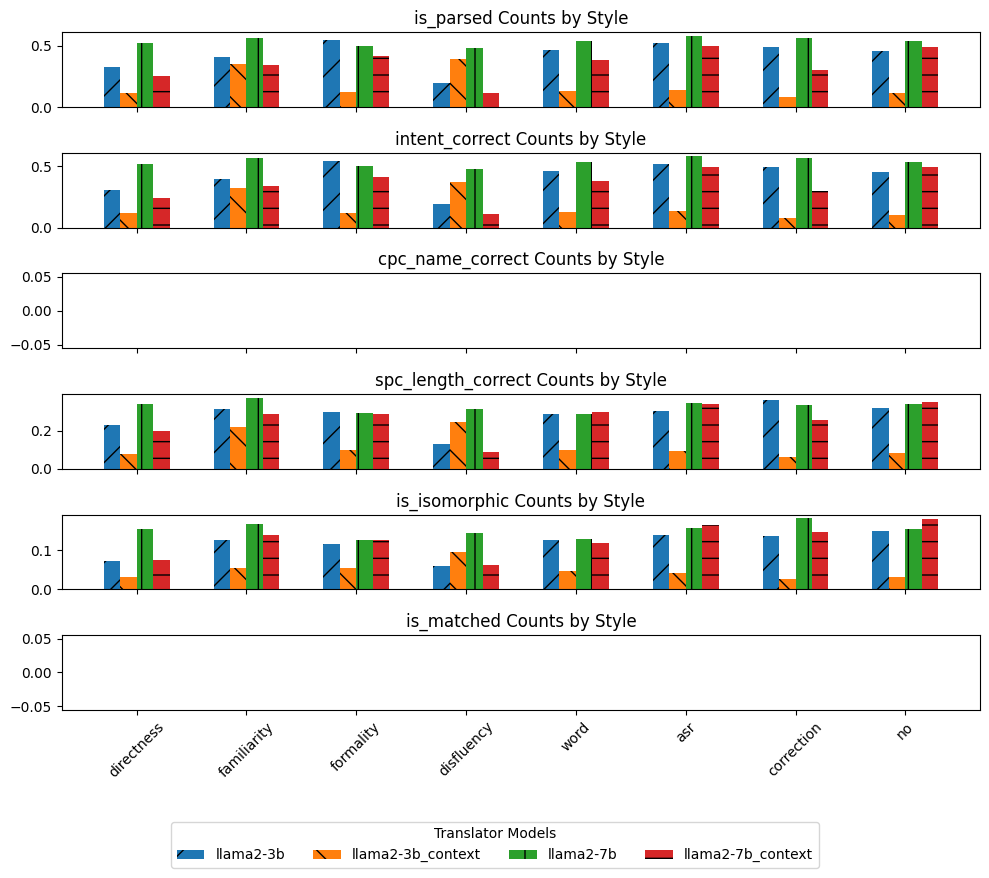

In [17]:
# Plotting 

import matplotlib.pyplot as plt
import numpy as np
import re

def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]
    
def get_model_name(text):
    if "no-context" in text:
        return "-".join(text.split("/")[1].split("-")[-2:])
    else:
        return "-".join(text.split("/")[1].split("-")[-2:]) + "_context"

def get_style_name(text):
    t = text.split(":")[1]
    return camel_case_split(t)[0].lower()

# shorten the names of the models 
# get all unique names - this can easily hande a couple tenthousand names
models = set(df["model"])
styles = set(df["stylizer"])

# create mapper: you would use fake.last_name() instead of 42+i
# mapper = {k: fake.last_name() for k in all_names }
mapper = {m: get_model_name(m)  for m in models}
mapper_styles = {s: get_style_name(s) for s in styles}

# apply it
df["model"] = df["model"].map(mapper)
df["stylizer"] = df['stylizer'].map(mapper_styles)

# List of evaluation columns
eval_columns = ['is_parsed', 'intent_correct', 'cpc_name_correct','spc_length_correct', 'is_isomorphic', 'is_matched']

# Get unique styles
styles = df['stylizer'].unique()

# Create subplots for each evaluation
fig, axes = plt.subplots(len(eval_columns), figsize=(10, 8), sharex=True)

# Define hatching patterns for models (for shading)
hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o']

# Iterate through each evaluation and plot grouped bars for each style
for i, eval_col in enumerate(eval_columns):
    ax = axes[i]
    ax.set_title(f'{eval_col} Counts by Style')
    
    # Filter the DataFrame for the current evaluation column
    eval_df = df[['stylizer', 'model', eval_col]]
    
    # Pivot the DataFrame to have 'style' as columns and 'model' as rows
    pivot_df = eval_df.pivot_table(index='stylizer', columns='model', values=eval_col, fill_value=False)
    
    # Create positions for grouped bars
    bar_positions = np.arange(len(styles))
    bar_width = 0.15
    
    # Plot grouped bars for each style with different shading patterns
    for j, model in enumerate(pivot_df.columns):
        ax.bar(bar_positions + j * bar_width, pivot_df[model], width=bar_width, label=model, hatch=hatch_patterns[j % len(hatch_patterns)])

    ax.set_xticks(bar_positions + (len(pivot_df.columns) - 1) * bar_width / 2)
    ax.set_xticklabels(styles, rotation=45)  # Rotate x-axis tick labels by 45 degrees

# Create a single legend below the subplots with horizontal layout
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Translator Models', loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(handles))


plt.tight_layout()
plt.show()

In [ ]:
df.columns

In [ ]:
df.iloc[0]

## Novelty

1. get a set of novel cpcs, and properties 
2. Label each item in the test datasets as novel or not "is_novel"
3. merge the translators and parsers into one dataset? maybe?

What are the questions i have?
- Novelty, Context, parser/translator
- mean evaluation score across all metrics

X axis: novelty vs not, four bars for each model, and y-axis is the average across all the different measures. 

Need to create one df that combines parsers and translators by going through all parsers and translators and extracting the following fields:

- novelty of data point
- model
- parser or translator
- context or not
- mean of all metrics



In [18]:
## PARSERS 

#p_f7_context_fn = "../data/evals/parser-info_structure-30k-context-falcon-7b_evaluation.json"
p_l3_context_fn_c = "../data/evals/parser-info_structure-2k-novelty-context-llama2-3b_evaluation.json_cleaned.csv"
p_l7_context_fn_c = "../data/evals/parser-info_structure-2k-novelty-context-llama2-7b_evaluation.json_cleaned.csv"

#p_f7_fn = "../data/evals/parser-info_structure-30k-no-context-falcon-7b_evaluation.json"
p_l3_fn_c = "../data/evals/parser-info_structure-2k-novelty-no-context-llama2-3b_evaluation.json_cleaned.csv"
p_l7_fn_c = "../data/evals/parser-info_structure-2k-novelty-no-context-llama2-7b_evaluation.json_cleaned.csv"


parsers_fn_c = [p_l3_fn_c, p_l7_fn_c]
parsers_context_fn_c = [p_l3_context_fn_c, p_l7_context_fn_c]
all_parsers_c = parsers_fn_c + parsers_context_fn_c

t_l3_context_fn_c = "../data/evals/translator-simple_english-2k-novelty-context-llama2-3b_evaluation_parsed.json_cleaned.csv"
t_l7_context_fn_c = "../data/evals/translator-simple_english-2k-novelty-context-llama2-7b_evaluation_parsed.json_cleaned.csv"

t_l3_fn_c = "../data/evals/translator-simple_english-2k-novelty-no-context-llama2-3b_evaluation_parsed.json_cleaned.csv"
t_l7_fn_c = "../data/evals/translator-simple_english-2k-novelty-no-context-llama2-7b_evaluation_parsed.json_cleaned.csv"

all_translators_c = [t_l3_fn_c, t_l7_fn_c, t_l3_context_fn_c, t_l7_context_fn_c]

In [19]:
eval_columns = ['is_parsed', 'intent_correct', 'cpc_name_correct','spc_length_correct', 'is_isomorphic', 'is_matched']

In [20]:
# Go through training data and identify the "known cpc and spcs" 
import json 
from scripts.evaluate import pred_name, pred_args
from gsp.preparation import deconstruct 

orig_training_file = "../data/tasks/dev/SpatialTrainingDataset.json"
with open(orig_training_file, "r") as f:
    orig = json.load(f)

cpcs = set()
spcs = set()
properties = set()
for item in orig['utterances']:
    json_semantics = deconstruct(item['desiredSemantics'])
    cpc_name = pred_name(json_semantics['central_proposition'])
    cpcs.add(cpc_name)
    for s in json_semantics['supplemental_semantics']:
        spc_name = pred_name(s)
        spcs.add(spc_name)

with open("../data/evals/known_cpcs.txt", "w") as f:
    for i in list(cpcs):
        f.write(f"{i}\n")
    
with open("../data/evals/known_spcs.txt", "w") as f:
    for i in list(spcs):
        f.write(f"{i}\n")


### Creating novelty charts

In [21]:
# Now that we  have our known cpcs and spcs we can start to work on our dataset 

from tqdm.notebook import tqdm 
from scripts.evaluate import pred_name, pred_args
import pandas as pd
import re
import ast

def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

def get_style_name(text):
    t = text.split(":")[1]
    return camel_case_split(t)[0].lower()

def get_model_name(text):
    if "no-context" in text:
        return "-".join(text.split("/")[1].split("-")[-2:])
    else:
        return "-".join(text.split("/")[1].split("-")[-2:]) + "_context"

known_cpcs = set()
with open("../data/evals/known_cpcs.txt", "r") as f:
    for line in f:
        known_cpcs.add(line.strip())

known_spcs = set()
with open("../data/evals/known_spcs.txt", "r") as f:
    for line in f:
        known_spcs.add(line.strip())

known_things = known_cpcs.union(known_spcs)

dfs = []
for t in tqdm(all_parsers_c + all_translators_c):
    print(t)
    df = pd.read_csv(t)
    print(len(df))
    dfs.append(df)
print("concatenating")
df = pd.concat(dfs)

# Append novelty, parser/not, context/not condition information into the dataset.
data_with_conditions = []
for index,row in df.iterrows():

    # copy all the preexisting fields into the item
    item = row.to_dict()
    
    # check if data is quasi novel with respect to the cpc and spc
    # check if cpc name in known things
    if pred_name(row['central_proposition']).lower() in known_things:
        item['cpc_novelty'] = False
    else:
        item['cpc_novelty'] = True

    # check if there are any SPCs that are not in known things
    spcs = set()    
    for spc in ast.literal_eval(item['supplemental_semantics']):
        spcs.add(pred_name(spc).lower())

    diff = spcs - known_things
    if not diff:
        item['spc_novelty'] = False
    else:
        item['spc_novelty'] = True

    # clean up model and style names
    style = get_style_name(row['stylizer'])
    model = get_model_name(row['model'])
    item['model'] = model
    item['style'] = style

    if "no-context" in row['model']:
        item['is_context'] = False
    else:
        item['is_context'] = True

    if "parser" in row['model']:
        item['model_type'] = "parser"
    else:
        item['model_type'] = "translator"
        
    data_with_conditions.append(item)
    
    

  0%|          | 0/8 [00:00<?, ?it/s]

../data/evals/parser-info_structure-2k-novelty-no-context-llama2-3b_evaluation.json_cleaned.csv
2473
../data/evals/parser-info_structure-2k-novelty-no-context-llama2-7b_evaluation.json_cleaned.csv
2473
../data/evals/parser-info_structure-2k-novelty-context-llama2-3b_evaluation.json_cleaned.csv
2473
../data/evals/parser-info_structure-2k-novelty-context-llama2-7b_evaluation.json_cleaned.csv
2473
../data/evals/translator-simple_english-2k-novelty-no-context-llama2-3b_evaluation_parsed.json_cleaned.csv
2473
../data/evals/translator-simple_english-2k-novelty-no-context-llama2-7b_evaluation_parsed.json_cleaned.csv
2473
../data/evals/translator-simple_english-2k-novelty-context-llama2-3b_evaluation_parsed.json_cleaned.csv
2473
../data/evals/translator-simple_english-2k-novelty-context-llama2-7b_evaluation_parsed.json_cleaned.csv
2473
concatenating


In [22]:
df_conditions = pd.DataFrame(data_with_conditions)
df_conditions.tail()

utterance  \
19779                           push the the sports ball   
19780  push the volleyball, no wait, i mean the sport...   
19781      push the round object, i mean the sports ball   
19782  push the soccer ball, actually no, i meant to ...   
19783                               push the sports ball   

                                          goal_semantics  \
19779  INSTRUCT(marlow,self:agent,push(self:agent,VAR...   
19780  INSTRUCT(marlow,self:agent,push(self:agent,VAR...   
19781  INSTRUCT(marlow,self:agent,push(self:agent,VAR...   
19782  INSTRUCT(marlow,self:agent,push(self:agent,VAR...   
19783  INSTRUCT(marlow,self:agent,push(self:agent,VAR...   

             base_utterance  \
19779  push the sports ball   
19780  push the sports ball   
19781  push the sports ball   
19782  push the sports ball   
19783  push the sports ball   

                                          json_semantics    intent  \
19779  {'intent': 'INSTRUCT', 'central_proposition': ...  INSTRUCT   
19780  {'intent': 'INSTRUCT', 'central_proposition': ...  INSTRUCT   
19781  {'intent': 'INSTRUCT', 'central_proposition': ...  INSTRUCT   
19782  {'intent': 'INSTRUCT', 'central_proposition': ...  INSTRUCT   
19783  {'intent': 'INSTRUCT', 'central_proposition': ...  INSTRUCT   

         central_proposition supplemental_semantics  \
19779  push(self:agent,VAR0)   ['sportsball(VAR0)']   
19780  push(self:agent,VAR0)   ['sportsball(VAR0)']   
19781  push(self:agent,VAR0)   ['sportsball(VAR0)']   
19782  push(self:agent,VAR0)   ['sportsball(VAR0)']   
19783  push(self:agent,VAR0)   ['sportsball(VAR0)']   

                             stylizer  augmenter  \
19779         style:ASRStyleAugmenter        NaN   
19780  style:CorrectionStyleAugmenter        NaN   
19781  style:CorrectionStyleAugmenter        NaN   
19782  style:CorrectionStyleAugmenter        NaN   
19783          style:NoStyleAugmenter        NaN   

                                                 actions  ... spc_precision  \
19779  ['throwamong', 'placeIn', 'lookForObject', 'pl...  ...           0.0   
19780  ['throwamong', 'placeIn', 'lookForObject', 'pl...  ...           0.0   
19781  ['throwamong', 'placeIn', 'lookForObject', 'pl...  ...           0.0   
19782  ['throwamong', 'placeIn', 'lookForObject', 'pl...  ...           0.0   
19783  ['throwamong', 'placeIn', 'lookForObject', 'pl...  ...           0.0   

      spc_recall is_parsed parse deconstructed cpc_novelty spc_novelty  \
19779        0.0     False   NaN            {}        True       False   
19780        0.0     False   NaN            {}        True       False   
19781        0.0     False   NaN            {}        True       False   
19782        0.0     False   NaN            {}        True       False   
19783        0.0     False   NaN            {}        True       False   

            style is_context  model_type  
19779         asr       True  translator  
19780  correction       True  translator  
19781  correction       True  translator  
19782  correction       True  translator  
19783          no       True  translator  

[5 rows x 36 columns]

In [23]:
print(df_conditions.loc[df_conditions['spc_novelty'] == True])

Empty DataFrame
Columns: [utterance, goal_semantics, base_utterance, json_semantics, intent, central_proposition, supplemental_semantics, stylizer, augmenter, actions, properties, prompt_template, text, input, output, instruction, predicted, model, base_model, evaluation, valid_json, intent_correct, cpc_name_correct, spc_length_correct, is_isomorphic, is_matched, spc_precision, spc_recall, is_parsed, parse, deconstructed, cpc_novelty, spc_novelty, style, is_context, model_type]
Index: []

[0 rows x 36 columns]


In [24]:
import plotly.express as px

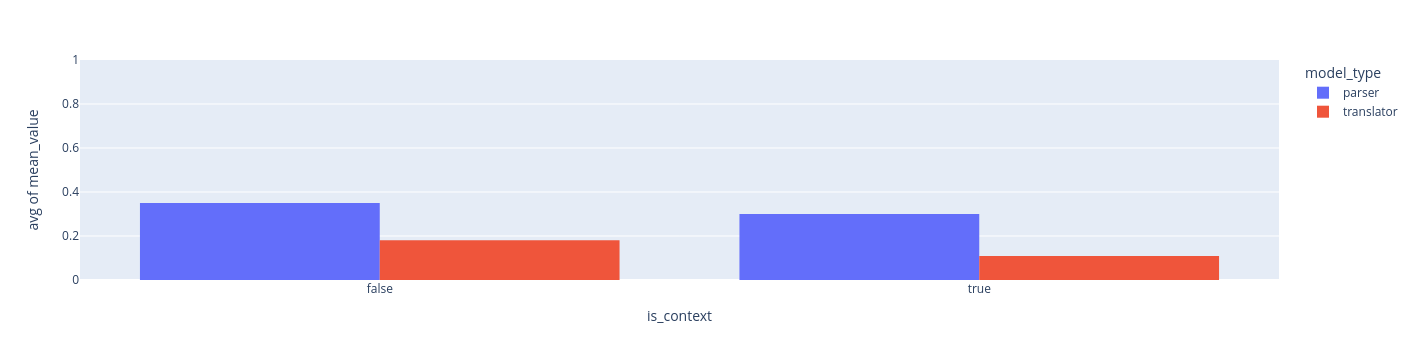

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# calculating a new column: mean value for every row 

for index, row in df_conditions.iterrows():
    metrics = ['intent_correct', 'cpc_name_correct','spc_length_correct', 'is_isomorphic', 'is_matched']
    values = []
    for m in metrics:
        if pd.isna(row[m]):
            values.append(False)
        else:
            values.append(row[m])
    mean_value = values.count(True)/len(values)
    df_conditions.at[index, "mean_value"] = mean_value

    # combining the model-type and context into one field 
    if row['is_context']:
        df_conditions.at[index, "model_condition"] = f"{row['model_type']} w/context"
    else:
        df_conditions.at[index, "model_condition"] = f"{row['model_type']}"


import plotly.express as px
# fig = px.histogram(df_conditions, x="spc_novelty", y="mean_value",
#              color='model_condition', barmode='group',
#              histfunc='avg',
#              height=400)

# fig.show()

fig = px.histogram(df_conditions, x="is_context", y="mean_value",
             color='model_type', barmode='group',
             histfunc='avg', width = 500)
fig.update_layout(yaxis_range=[0,1])

fig.show()

In [ ]:
df.head()

# Exploring the results (seeking out specific examples)

Generate an example for each style


In [60]:
example_base = "../data/evals/parser-info_structure-30k-no-context-llama2-7b_evaluation.json"
base = "../data/great/SpatialTrainingDataset_original.jsonl"

data = []
with open(base, "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
for index, row in df.iterrows():
    if " in " in row ['utteranceText']:
        print(row ['utteranceText'])

i want the knife in front of the spoon
take an orange in a microwave
take a sports ball in front of an umbrella
set a handbag in front of the keyboard
place the skis in front of the tie
i want a remote in front of a skateboard
place a broccoli in front of a sink
i want a car in front of the hot dog
put the train in front of a traffic light
take a fork in front of a car
place the suitcase in front of a sports ball
get the sandwich in front of the toothbrush
i want a sports ball in front of the cake
take the sheep in front of a hair drier
take the bird in front of a hair drier
lay the sandwich in the cow
get the person in a skateboard
stick a hair drier in the orange
get a fork in the chair
place the hot dog in front of the kite


In [ ]:
for index,row in df.iterrows():
    if row['intent'] == "INSTRUCT":
        if 

# MISC


In [ ]:
camel_case_split("style:DirectnessStyleAugmenter")

In [ ]:
# spot test
with open(p_l3_fn, "r") as f:
    p_l3 = json.load(f)

In [ ]:
df = pd.DataFrame(p_l3)

In [ ]:
df.iloc[0]['evaluation']

In [ ]:
df = pd.DataFrame({'num_legs': [True, False, True, True],
                   'num_wings': [2, 0, 0, 0]},
                  index=['falcon', 'dog', 'cat', 'ant'])

In [ ]:
out = df.value_counts("num_legs", normalize=True)

In [ ]:
`out[True]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame (replace this with your actual DataFrame)
data = {
    'eval1': [True, False, True, False],
    'eval2': [False, True, True, True],
    'eval3': [True, True, False, True],
    'eval4': [False, False, True, True],
    'style': ['A', 'B', 'A', 'B'],
    'model': ['Model1', 'Model2', 'Model1', 'Model2']
}

df = pd.DataFrame(data)

# List of evaluation columns
eval_columns = ['eval1', 'eval2', 'eval3', 'eval4']

# Get unique styles
styles = df['style'].unique()

# Create subplots for each evaluation
fig, axes = plt.subplots(len(eval_columns), figsize=(10, 8), sharex=True)

# Define colors for models
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Iterate through each evaluation and plot grouped bars for each style
for i, eval_col in enumerate(eval_columns):
    ax = axes[i]
    ax.set_title(f'{eval_col} Counts by Style')
    
    # Filter the DataFrame for the current evaluation column
    eval_df = df[['style', 'model', eval_col]]
    
    # Pivot the DataFrame to have 'style' as columns and 'model' as rows
    pivot_df = eval_df.pivot_table(index='style', columns='model', values=eval_col, fill_value=False)
    
    # Create positions for grouped bars
    bar_positions = np.arange(len(styles))
    bar_width = 0.15
    
    # Plot grouped bars for each style with different colors
    for j, model in enumerate(pivot_df.columns):
        ax.bar(bar_positions + j * bar_width, pivot_df[model], width=bar_width, label=model, color=colors[j % len(colors)])

    ax.set_xticks(bar_positions + (len(pivot_df.columns) - 1) * bar_width / 2)
    ax.set_xticklabels(styles, rotation=45)  # Rotate x-axis tick labels by 45 degrees
    ax.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame (replace this with your actual DataFrame)
data = {
    'eval1': [True, False, True, False],
    'eval2': [False, True, True, True],
    'eval3': [True, True, False, True],
    'eval4': [False, False, True, True],
    'style': ['A', 'A', 'B', 'B'],
    'model': ['Model1', 'Model2', 'Model1', 'Model2']
}

df = pd.DataFrame(data)

# List of evaluation columns
eval_columns = ['eval1', 'eval2', 'eval3', 'eval4']

# Get unique styles
styles = df['style'].unique()

# Create subplots for each evaluation
fig, axes = plt.subplots(len(eval_columns), figsize=(10, 8), sharex=True)

# Define colors for models
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Iterate through each evaluation and plot the grouped bar chart
for i, eval_col in enumerate(eval_columns):
    ax = axes[i]
    ax.set_title(f'{eval_col} Counts by Style')
    
    # Filter the DataFrame for the current evaluation column
    eval_df = df[['style', 'model', eval_col]]
    
    # Pivot the DataFrame to have 'style' as columns and 'model' as rows
    pivot_df = eval_df.pivot_table(index='style', columns='model', values=eval_col, fill_value=False)
    
    # Create positions for bars
    bar_positions = np.arange(len(styles))
    bar_width = 0.15
    
    # Plot bars for each model with different colors
    for j, model in enumerate(pivot_df.columns):
        ax.bar(bar_positions + j * bar_width, pivot_df[model], width=bar_width, label=model, color=colors[j % len(colors)])

    ax.set_xticks(bar_positions + (len(pivot_df.columns) - 1) * bar_width / 2)
    ax.set_xticklabels(styles)
    ax.legend(title='Model')

plt.tight_layout()
plt.show()
